# EX 10. News Summarization


텍스트 요약
상대적으로 긴 문장으로 짧은 문장으로 변환하는 기법을 텍스트 요약이라고 합니다. Ex 10에서는 뉴스 요약을 해보겠습니다.

텍스트 요약에는 두 가지 방법, Extractive Summarization, Abstractive Summarization이 있습니다. Extractive의 경우 가장 의미있는 문장을 원문 안에서 추출해 내는 방식이고, Abstractive는 원문을 요약하는 새로운 문장을 만들어내는 방식입니다.

이 프로젝트에서는 원문과 그에 해당하는 요약문을 주고(지도학습) seq2seq와 Attention을 사용하여 원문 -> 요약문으로의 Abstractive Summarization을 실시하겠습니다. 이는 일반적인 번역과 매우 유사한 과정을 거치는 것입니다.



평가문항
1. Abstractive 모델 구성을 위한 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.


2. 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.


3. Abstractive 요약 결과과 함께 비교해 보았다. 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.


## 1. 데이터 수집하기

이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.
| abstractive 요약 

                Abstractive 	Extractive 요약
        text	     사용 O	사용 O
        headlines    사용 O	사용 X

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('Done')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Done


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:

data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


모델이 text를 입력받아 context vector를 만들어내고, 출력단이 context vector를 통해 headlines와 가까운 문장을 만들어내는 것이 목표입니다.

In [5]:
data = data[['text', 'headlines']]
data.sample(10)

,text,headlines
18227,Japan has acknowledged for the first time that...,Japan admits 1st death from 2011 Fukushima nuc...
42956,Facebook is reportedly under investigation by ...,US investigating Facebook for use of personal ...
7815,Foodtech startup Zomato has announced that it ...,Zomato to expand to 30 more Indian cities
93349,"Claiming that Infosys was fighting the ""wrong ...","Infosys is fighting the wrong battle, says adv..."
30953,After the BJP emerged as the single largest pa...,BJP not confined to Hindi-speaking states: PM ...
63017,The Archaeological Survey of India (ASI) has a...,Mahabharata's House of Lac to be excavated
51244,Researchers at a German research laboratory ha...,Electronic 'skin' which lets users control obj...
28582,Two Indian-American owners of a bulk mailing c...,2 Indian-Americans accused of Ã¢ÂÂ¹110 cr pos...
42877,A second sexual harassment case has been filed...,Mahesh Murthy faces second sexual harassment case
52159,The makers of 'Padmaavat' have issued full-pag...,7 disclaimers listed in full-page newspaper ad...


In [6]:
print('전체 샘플 수:', len(data))

전체 샘플 수: 98401


### 2.1 중복 샘플과 NULL 값이 존재하는 샘플 제거


In [7]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [8]:
# text 중복 샘플 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
# Null Check
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


In [10]:
# 결측치를 제거합니다.
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2. Preprocessing data 


자연어 데이터의 문제를 완화하는 전처리를 시도합니다. "you're"과 "you are "은 같은 말이고, "너는"과 "넌" 역시 같은 말입니다. 또한, '.........'과 '...............' 을 서로 다른 단어으로 생각할 것인지, '.'라는 단어가 여러 개 나열 된 것은 동일하지만 그 개수에서 차이를 보인다고 생각할 것인지에 대해 명확한 규정이 존재하지 않으므로, 어떤 판단기준으로 단어를 선정할 것인지는 엔지니어에 달려 있습니다. 모델이 학습할 때 혼란을 덜어줄 것 같은 전처리를 직관적이지만, 가장 효율적인지 알 수 없는(hueristic) 방법으로 진행하겠습니다.

### 2.2 정규화 사전

In [11]:
# 정규화 사전 - 축약어를 분해할 때 사용합니다
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 2.3 불용어 사전

In [12]:
# 불용어 사전 - 문맥과 무관하게 자주 나와 context vector에 담겨있는 정보를 희석할 
#               염려가 있는 단어는 사용하지 않도록 합니다.
 
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

불용어 사전에서 의문이 드는 점은, 부정어(no, not, nor, but)등도 포함되어 있다는 점인데, 이들은 사용하도록 하겠습니다. 또한, 뉴스에서 의미를 파악하는데 중요할 것 같은 단어도 사용하도록 하겠습니다

In [13]:
# 불용어 제거는 text 전처리 시에만 호출, headlines는 상대적으로 문장 길이가 짧음
# Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Headlines에 남아 있는 게 더 좋을 것 같습니다.
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
preprocess_sentence("Helloooooo, ....!........what's your name??????????????  not so good?")

'helloooooo name good'

In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.


everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


### 2.5 멀티프로세싱

multiprocessing을 이용하여 전체 문장을 전처리합니다

In [16]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(df, col, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data[col], num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print("{} : {} seconds".format(col, time.time() - start_time))
    return processed_data

clean_text = preprocess_data(data,'text')  # 클라우드 기준으로 3~4분 정도 소요 됩니다

clean_headlines = preprocess_data(data, 'headlines', remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.

text : 434.80865693092346 seconds
headlines : 14.514250040054321 seconds


In [17]:
#text : 735.3365228176117 seconds
#headlines : 149.51734685897827 seconds
#clean_text = process_data(data, 'text')
#clean_headlines = process_data(data, 'headlines')

In [24]:
print(clean_headlines)

['upgrad learner switches to career in ml al with salary hike'
 'delhi techie wins free food from swiggy for one year on cred'
 'new zealand end rohit sharma led india match winning streak' ...
 'the matrix film to get reboot reports'
 'snoop dogg aims gun at clown dressed as trump in new video'
 'madhesi morcha withdraws support to nepalese government']


텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋아요. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되 면 샘플 자체가 빈 값을 가지게 되겠죠.

In [25]:
#DataFrame으로 저장합니다
data['Text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [26]:
# 결측치 확인 74개의 빈 summary 확인되었습니다
data.isnull().sum()

text         0
headlines    0
Text         0
dtype: int64

In [27]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2.6 샘플의 최대 길이 정하기

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


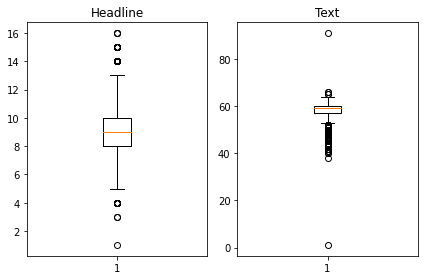

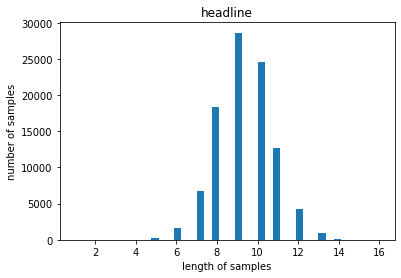

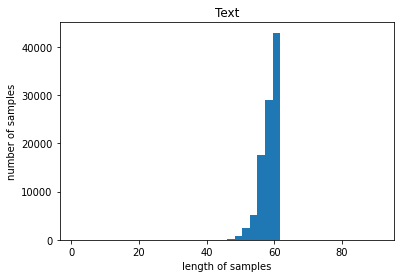

In [30]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('Headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

데이터의 분포가 넓게 퍼져있음을 알 수 있습니다. 이 프로젝트의 목표는 긍정/부정 분석이 아니고, 뉴스를 요약하는 것이며, 짧은 Text의 경우, padding을 pre로 주게 된다면, 해당 단어가 연이은 padding 뒤에 나와 그에 연관된 context vector가 희석 없이 decoder로 넘어가게 되어 오히려 너무 강한 영향력을 행사할 것 같습니다. 따라서 짧은 텍스트에서 얻을 수 있는 정보는 모두 긴 Text에서 충분히 얻을 수 있다고 가정하고 너무 짧거나 긴 Text를 갖는 데이터포인트를 제거하겠습니다

headline은 6-15 사이에 많은 데이터들이 있고, text는 45-65사이에 대부분의 데이터가 있음을 확인할 수 있습니다!

In [61]:
# 최소, 최대 사이에 있는 샘플을 골라 냅니다.
def below_threshold_len(min_len, max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len) and (len(s.split()) >= min_len):
            cnt = cnt + 1
    print(f'전체 샘플 중 길이가 {min_len} 이상,{max_len} 이하인 샘플의 비율:{cnt / len(nested_list)}')
    
    
    print('text')
below_threshold_len(50, 60, data['text'])
print('--------------------------------------------------------------')
print('headline')
below_threshold_len(5, 12,  data['headlines'])

전체 샘플 중 길이가 50 이상,60 이하인 샘플의 비율:1.0
text
--------------------------------------------------------------
headline
전체 샘플 중 길이가 5 이상,12 이하인 샘플의 비율:1.0
text


In [56]:
text_max_len = 60; text_min_len = 50

headline_max_len = 11; headline_min_len = 6

In [57]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len \
            and len(x.split()) >= text_min_len)]


data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len and len(x.split()) >= headline_min_len)]


print('전체 샘플수 :', (len(data)))

전체 샘플수 : 91997


In [58]:
data

,text,headlines,Text
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
2,New Zealand defeated India by 8 wickets in the...,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
5,Pakistani singer Rahat Fateh Ali Khan has deni...,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...
7,Weeks after ex-CBI Director Alok Verma told th...,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...
...,...,...,...
98395,"Pakistan has started building a nearly 2,400-k...",pakistan starts building fence along afghanist...,pakistan started building nearly kilometer fen...
98396,A CRPF jawan was on Tuesday axed to death with...,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...
98397,"'Uff Yeh', the first song from the Sonakshi Si...",first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...
98398,"According to reports, a new version of the 199...",the matrix film to get reboot reports,according reports new version science fiction ...


### 2.7 시작 토큰과 종료 토큰 추가하기

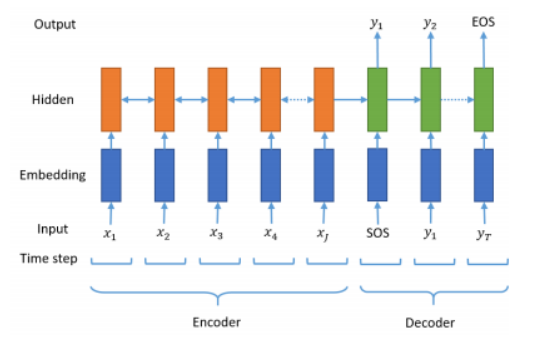


Seq2Seq | decoder_input(입력) | decoder_target (출력, 레이블)
    -----|-----|----- 
시작토큰 | sostoken +~ | 
종료토큰 |  | ~+ eostoken


In [63]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x) # 문장 앞에 sostoken을 추가해준다.
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken') # 문장 뒤에 eostoken을 추가해준다.
data.head()

,text,headlines,Text,decoder_input,decoder_target
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,New Zealand defeated India by 8 wickets in the...,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,Pakistani singer Rahat Fateh Ali Khan has deni...,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,Weeks after ex-CBI Director Alok Verma told th...,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [64]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장 (np.array)
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 2.8 훈련 데이터와 테스트 데이터 분리 (# train test split)

np.random.shuffle을 사용하여 섞인 데이터를 8:2 비율로 훈련 데이터와 테스트 데이터로 분리한다.

In [74]:
# Indices 를 설정! (why?? : 순서(index)를 필요로 하기에!)
indices = np.arange(encoder_input.shape[0]) # indices에 인코더를 넣어준다. input shape를 맞춰줘야 한다.
np.random.shuffle(indices) # 랜덤하게 섞어서 과적합을 막는 용도???
print("Indices are :", +  indices)



# encoder input과 decoder target을 설정한다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('\n테스트 데이터의 수 :', n_of_val)




# train_set으로 만들어준다! (encoder_input과 decoder_target을 가지고)
# Q: 왜 decoder target이 필요할까??
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# test_set 을 만들어준다! (encoder_input과 decoder_target을 가지고)
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

Indices are : [59758   399 38966 ... 29663 34224 61546]

테스트 데이터의 수 : 18399
훈련 데이터의 개수 : 73598
훈련 레이블의 개수 : 73598
테스트 데이터의 개수 : 18399
테스트 레이블의 개수 : 18399


### 2.9 정수 인코딩

1. Tokenizer() = 텍스트를 토큰화


2. fit_on_texts() = 입력 데이터로부터 단어 집합 생성, 각 단어에 고유한 정수가 부여


3. word_index = 생성된 단어 집합


4. word_counts = 각 단어와 그 단어의 등장 빈도수가 저장되어있는 딕셔너리


5. texts_to_sequences() = 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다.

In [75]:
src_tokenizer = Tokenizer() # 토크나이저 정의 (src를 사용)
src_tokenizer.fit_on_texts(encoder_input_train) # encoder에서 입력된 데이터로부터 단어 집합 생성 

In [76]:
# 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 88807
등장 빈도가 8번 이하인 희귀 단어의 수: 67952
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20855
단어 집합에서 희귀 단어의 비율: 76.51649081716532
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.383274863477273


In [77]:
# 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기는 20838이다.
src_vocab = 20838
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20838으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성. (encoder를 사용)

In [78]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[64, 17, 506, 2, 675, 255, 58, 198, 132, 377, 16, 106, 58, 2134, 290, 116, 24, 506, 2, 1, 2125, 3663, 675, 2139, 1, 3533, 10030, 389, 346, 2, 1475, 666, 6, 3871, 118, 132, 5798, 222, 4, 1, 17802, 1043, 1175, 1, 5, 152, 290, 1, 2139, 12, 266, 7, 644, 124, 37, 31], [1, 382, 23, 5025, 18, 2, 1834, 5200, 4796, 19, 1, 141, 4835, 1, 1158, 268, 1, 1834, 1089, 29, 12, 48, 174, 4, 15584, 23, 25, 430, 18, 644, 589, 69, 1, 73, 105, 305, 2363, 2042, 23, 2108, 1, 382, 51, 10, 1, 73, 2363, 23, 25, 62, 5, 1, 339, 189, 3070, 937, 1460], [1, 323, 978, 5, 1, 273, 2483, 278, 693, 8, 30, 163, 20, 538, 765, 205, 1475, 1, 254, 1898, 5, 3, 420, 6, 336, 16, 144, 1, 1306, 308, 702, 43, 33, 5685, 90, 727, 4, 1, 405, 591, 2910, 794, 3810, 2, 6186, 16, 50, 11, 787, 1, 189]]


In [79]:
# 헤드라인 데이터에도 동일한 작업 수행
tar_tokenizer = Tokenizer() # target tokenizer
tar_tokenizer.fit_on_texts(decoder_input_train) # decoder train



threshold = 9
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29462
등장 빈도가 8번 이하인 희귀 단어의 수: 21543
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7919
단어 집합에서 희귀 단어의 비율: 73.1213088045618
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.9922732425848055


In [80]:
# 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7919
tar_vocab = 7919
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input ',decoder_input_train[:5])
print('decoder ',decoder_target_train[:5])

input  [[1, 23, 1447, 42, 41, 1033, 373, 429, 192, 1497], [1, 82, 3, 4471, 12, 3, 1222, 3245, 10, 1411], [1, 368, 826, 6, 1089, 363, 1753], [1, 295, 727, 24, 3, 171, 786, 509, 2762], [1, 75, 31, 20, 549, 38, 9, 980, 208, 4, 51]]
decoder  [[23, 1447, 42, 41, 1033, 373, 429, 192, 1497, 2], [82, 3, 4471, 12, 3, 1222, 3245, 10, 1411, 2], [368, 826, 6, 1089, 363, 1753, 2], [295, 727, 24, 3, 171, 786, 509, 2762, 2], [75, 31, 20, 549, 38, 9, 980, 208, 4, 51, 2]]


In [81]:
# 결측치 제거 - eostoken만 남은 경우를 제거한다. 아마 없을 것이다
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 73598
훈련 레이블의 개수 : 73598
테스트 데이터의 개수 : 18399
테스트 레이블의 개수 : 18399


### Padding

encoder의 경우, padding을 뒤에 넣으면 context vector가 희석되므로 앞에 padding을 넣습니다

In [83]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

## 3. 어텐션 메커니즘 사용하기 (추상적 요약)



1. Encoder 설계
2. Decoder 설계
3. Attention 적용
4. 인퍼런스 모델



### 3.1 Encoder 설계

#### INPUT

    text_max_len = 50

#### Embedding

    src_vocab = 10838, embedding_dim = 128




### LSTM

##### hidden_state : LSTM에서 얼만큼의 수용력(Capacity)를 가질지를 정하는 파라미터
 -  이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수 다른 신경망과 마찬가지로 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가지는 않는다.


##### return_sequences : 시퀀스 출력 여부
return_sequences = True로 설정할 경우 각 time step별 hidden state를 모두 출력하게 된다. Attention을 사용할 때 주로 설정한다.


##### return_state : 시퀀스 출력 여부
return_state = True 를 한 경우에는 마지막 time step에서의 output(hidden state), hidden state와 cell state가 출력된다


##### dropout
0과 1사이 부동소수점. 인풋의 선형적 변형을 실행하는데 드롭시킬(고려하지 않을) 유닛의 비율.


##### recurrent_dropout

 - 0과 1사이 부동소수점. 순환 상태의 선형적 변형을 실행하는데 드롭시킬(고려하지 않을) 유닛의 비율.

1. 'encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)'

2. 'encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)'

3. 'encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)'

In [84]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더 (40,)
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층 (20000, 128)
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

### 3.2 Decoder 설계
디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다.

하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야한다.



##### INPUT

    shape=(None,)

##### Embedding

    tar_vocab = 9700, embedding_dim = 128

#### LSTM

    1. decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)



#### 출력층
디코더의 출력층에서는 다중 클래스 분류 문제를 풀어하므로 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용한다.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq 구조다.

그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있는데 바로 
**어텐션** 메커니즘이다

In [85]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [89]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2667264     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 3.3  Attention 적용

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있다.

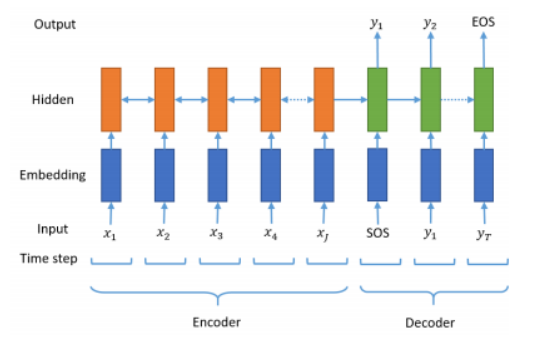


In [87]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [92]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2667264     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [93]:
# 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train],
                    y=decoder_target_train,
                    validation_data=(
                        [encoder_input_test, decoder_input_test],decoder_target_test),
                    batch_size=256,
                    callbacks=[es],
                    epochs=50)

Epoch 1/50
288/288 [==============================] - 280s 930ms/step - loss: 6.0520 - val_loss: 5.4269
Epoch 2/50
288/288 [==============================] - 272s 943ms/step - loss: 5.3297 - val_loss: 5.0323
Epoch 3/50
288/288 [==============================] - 265s 920ms/step - loss: 4.9349 - val_loss: 4.7471
Epoch 4/50
288/288 [==============================] - 265s 920ms/step - loss: 4.6239 - val_loss: 4.5061
Epoch 5/50
288/288 [==============================] - 265s 920ms/step - loss: 4.3778 - val_loss: 4.3530
Epoch 6/50
288/288 [==============================] - 265s 920ms/step - loss: 4.1782 - val_loss: 4.2299
Epoch 7/50
288/288 [==============================] - 265s 919ms/step - loss: 4.0178 - val_loss: 4.1279
Epoch 8/50
288/288 [==============================] - 265s 920ms/step - loss: 3.8762 - val_loss: 4.0605
Epoch 9/50
288/288 [==============================] - 265s 920ms/step - loss: 3.7470 - val_loss: 3.9832
Epoch 10/50
288/288 [==============================] - 265s 920m

In [94]:
# 6. 모델 저장하기
from keras.models import load_model
model.save('attention_seq2seq.h5')

model.save_weights('news_summarizer_weights_1')

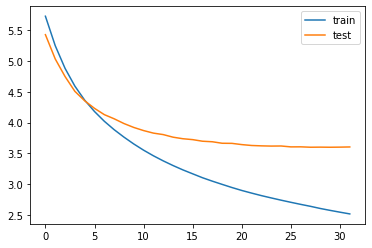

In [105]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 4. 인퍼런스 모델 구현

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [95]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 A집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

**seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다**


훈련 단계

 - 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.


인퍼런스 단계

 - 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [96]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [97]:
# 어텐션 메커니즘을 사용하는 출력층을 설계


# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [99]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

#### 모델 테스트


테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

In [100]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교한다.

In [101]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 Headline :", seq2summary(decoder_input_test[i]))
    print("예측 Headline :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : the madhya pradesh education department has decided to replace marks with in the report cards of class 1 and 2 government school students the move aims to reduce stress caused by parents over marks students will be given one two or three depending on how well they have the subject reports said 
실제 Headline : to replace marks for class and kids in mp 
예측 Headline :  mp to introduce school for students in mp


원문 : a drunk woman who was caught for rash driving started hugging and kissing a policeman after he approached her kolkata police said on thursday other policemen stopped her after seeking the help of another woman nearby the incident occurred around midnight and the accused in her late was taken to the police station with two other people accompanying her 
실제 Headline : kolkata woman caught for driving kisses policeman 
예측 Headline :  drunk woman denied drunk driving in up police station


원문 : nearly 1 500 newspaper vendors have asked the authorities to stop the ongoing evic

## 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다.

Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아본다.

1. text (str) : 요약할 테스트.


2. ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값


3. words (int or None, optional) – 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.


4. split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환



Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다.. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여본다. 원문의 0.005%만을 출력하도록 설정했다.

In [106]:

import requests
from summa.summarizer import summarize

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [107]:
for i in range(10):
    print("실제 HEADLINE : ", data['headlines'][i])
    print("추출적 요약 HEADLINE : ", summarize(data['text'][i], ratio=0.5))
    print("\n")

실제 HEADLINE :  upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 HEADLINE :  upGrad's Online Power Learning has powered 3 lakh+ careers.


실제 HEADLINE :  Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 HEADLINE :  Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


실제 HEADLINE :  New Zealand end Rohit Sharma-led India's 12-match winning streak
추출적 요약 HEADLINE :  The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


실제 HEADLINE :  Aegon life iTerm insurance plan helps customers save tax
추출적 요약 HEADLINE :  Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.


실제 HEADLINE :  Have known Hirani for yrs, what if MeToo claims are not true: Sonam
추출적 요약 HEADLINE :  Speaking about the sexual harassment a